<a href="https://colab.research.google.com/github/gamecicn/sample_jupyter/blob/main/Emotion_glvoe_LSTM_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import re
from tqdm import tqdm_notebook

from nltk.corpus import stopwords
import pandas as pd
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 300      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "/content/drive/My Drive/GlovePretrain/glove.42B."+str(EMBEDDING_DIM)+"d.txt"

train = pd.read_csv('/content/drive/My Drive/DS_data/ISEAR_train.csv')




In [28]:
labels_arr = train.emotion.factorize()

labels = labels_arr[1].tolist()
#y = [[x] for x in labels_arr[0]]
y = labels_arr[0]

comments_train = train['text']
comments_train = list(comments_train)

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Text Pre-processing

In [33]:
def clean_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")
    
texts = [] 

for line in tqdm_notebook(comments_train, total=len(y)): 
    texts.append(clean_text(line))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


In [34]:
print('Sample data:', texts[1], y[1])

Sample data: hristmas holdidays wanted invite brother á girlfriend child dinner said á brothers girlfriend would like come place á dinner refused never mentioned á never as 1


In [35]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 11557


In [36]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (7795, 200)
Shape of label tensor: (7795,)


In [37]:
import numpy as np

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [38]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  18632
validation:  4734


In [39]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [1046 1101 2345 4574 3362    1 2345 7056 1618 1922 1150 7057    4    1
 2755    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [40]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/My Drive/GlovePretrain/glove.42B.300d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [43]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [44]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

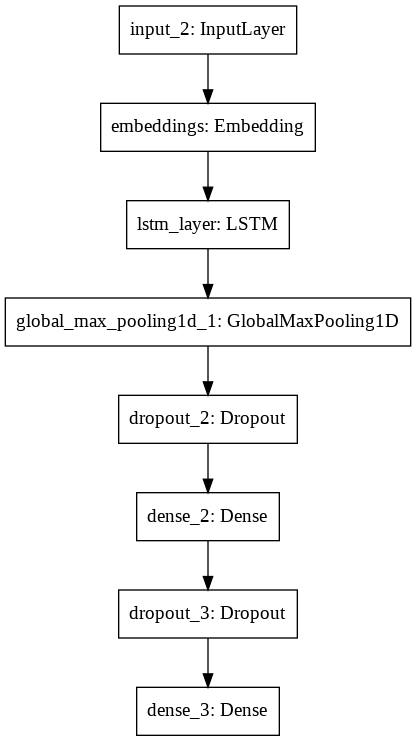

In [45]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [50]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 5, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/5
195/195 [==============================] - 27s 141ms/step - loss: -1832.1379 - accuracy: 0.1459 - val_loss: -2623.1487 - val_accuracy: 0.1309
Epoch 2/5
195/195 [==============================] - 28s 143ms/step - loss: -3440.3948 - accuracy: 0.1459 - val_loss: -4520.0425 - val_accuracy: 0.1309
Epoch 3/5
195/195 [==============================] - 27s 140ms/step - loss: -5516.9097 - accuracy: 0.1459 - val_loss: -6864.3745 - val_accuracy: 0.1309
Epoch 4/5
195/195 [==============================] - 28s 143ms/step - loss: -8013.1772 - accuracy: 0.1459 - val_loss: -9644.1416 - val_accuracy: 0.1309
Epoch 5/5
195/195 [==============================] - 28s 141ms/step - loss: -10970.4746 - accuracy: 0.1459 - val_loss: -12817.1445 - val_accuracy: 0.1309


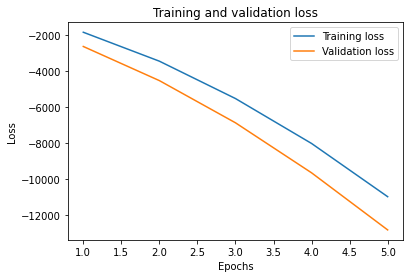

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

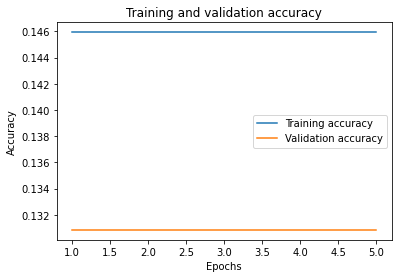

In [52]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();